# Macro-Induced Lightning Constraints

In [1]:
"""
    TITLE   : Macro-Induced Lightning Constraints
    AUTHOR  : Jagjit Sidhu, Nathaniel Starkman
    PROJECT : https://github.com/nstarman/macro_lightning
""";

__author__ = ['Jagjit Sidhu', "Nathaniel Starkman"]

<span style='font-size:30px;font-weight:650'>
    About
</span>

This notebook contains the calculations for how well macro-induced lightnint on Earth and Jupiter can constrain macro models.


<br><br>

- - - 


## Prepare

### Imports

In [2]:
# BUILT-IN

import sys
from itertools import product as iterprod

# THIRD PARTY

from astropy import units as u
from astropy.table import QTable
import matplotlib.pyplot as plt
import numpy as np
import utilipy
from tqdm import tqdm


# PROJECT SPECIFIC

from macro_lightning import plot, physics as ph
from macro_lightning import parameters
from macro_lightning.physics import f_BM_bin
from macro_lightning.utils import as_quantity, qsquare, qnorm, qarange


set autoreload to 1


### Parameters

In [3]:
load_saved = True

In [4]:
PI = np.pi
KMS = u.km / u.s

vcirc = 220.0 * KMS
vvir = 250 * KMS  # virial velocity
vesc = 550 * KMS  # Galactic escape velocity

v_start = -500 * KMS
v_step = 25 * KMS  # bin size

vels = qarange(v_start, vesc + v_step, v_step, unit=KMS)[::-1]

# Mass
m_unit = u.g
m_arr = np.logspace(1, 25)

# Cross-Section
sigma_unit = u.cm**2
sigmin, sigmax = 1e-15, 1e25
min_sigma = 6e-8 * u.cm ** 2  # minimum observable sigma from lightning


<br><br>

- - - 


## Earth

We first perform the integral $$\Gamma(M_x, \sigma_x) = A_{det}\frac{\rho_{DM}}{M_x} \int_{v_{threshold}(\sigma_x;D)}^{v_{esc}}v_x f_{MBSS}(v_x) \rm{d}v_x $$

from https://arxiv.org/pdf/1908.00557.pdf

In [5]:
vesc_sun_at_earth = 42.1 * u.km / u.s  # from https://ssd.jpl.nasa.gov/?planet_phys_par
vesc_earth = parameters.solar_system_vesc_params.get()["Earth"]

# vmin = ph.multibody_esc_v(vesc_sun_at_earth, vesc_earth)
vminE = qnorm(vesc_sun_at_earth, vesc_earth)
vminE


ArhoE = 3 * u.g * u.s / u.m  # A_{det}*\rho_{DM}

# eqn 7 of the lightning paper, setting $\lambda_e^{macro} \geq \lambda_e^{natural}$
sigma_factor_earth = 1e8 * (u.cm**2 / u.s) ** 2

<Quantity 43.56175042 km / s>

In [6]:
try:
    if load_saved:
        macro = QTable.read("macro_msig_earth.asdf", format="asdf")
    else:
        raise Exception("load_saved = False")

except Exception as e:
    print("Can't load, ", e)

    massE, sigmaE, *_ = ph.calculate_Mx_and_Sx(
        vels,
        vvir=vvir,
        vesc=vesc,
        vcirc=vcirc,
        vmin=vminE,
        Arho = ArhoE,
        # kwargs
        minsigma=min_sigma,
        m_unit=m_unit,
        sigma_factor=sigma_factor_earth,
        sig_unit=sigma_unit
    )

    macro = QTable([massE, sigmaE], names=["mass", "sigma"])
    macro.write("macro_msig_earth.asdf", format="asdf")

else:
    massE = macro["mass"]
    sigmaE = macro["sigma"]


**Plot Constraints**

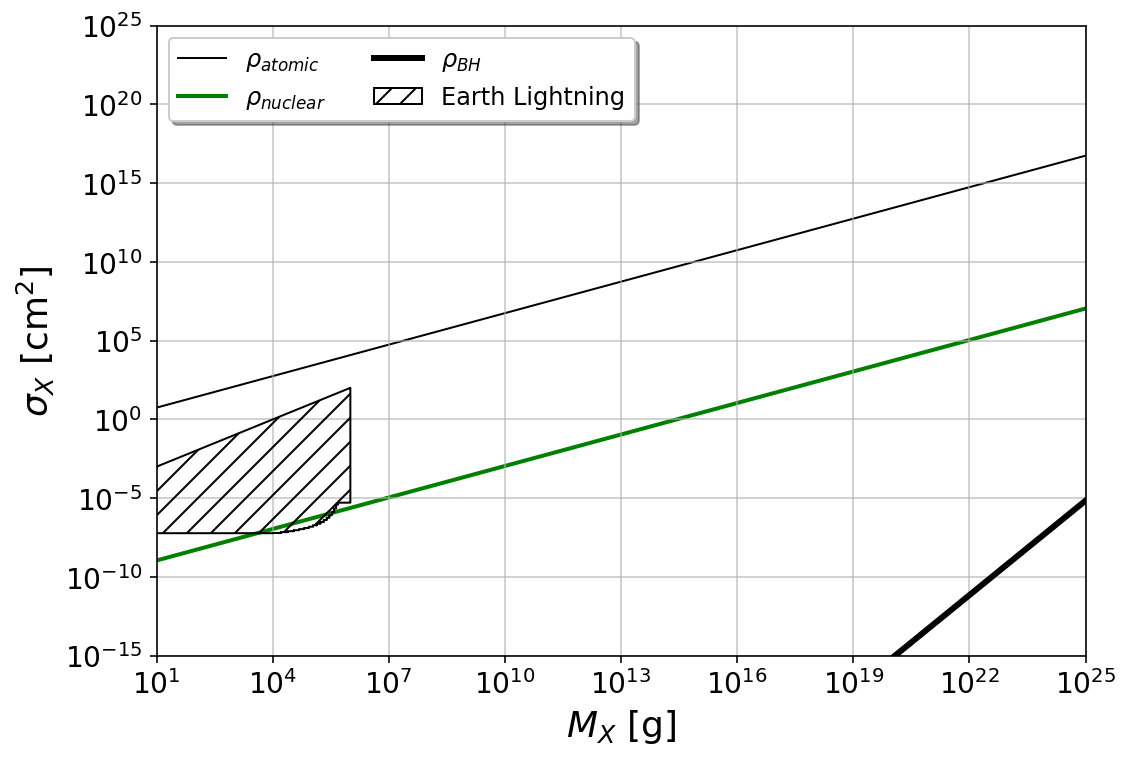

In [7]:
upperlightning = massE * 1e-4 * u.cm**2 / u.g

with plot.constraints_plot(m_arr, sigmin=sigmin):

    plt.fill_between(
        massE, sigmaE, upperlightning,
        where=None, 
        facecolor='none',
        edgecolor='black',
        hatch="//",
        alpha=1.0,
        zorder=8,
        label="Earth Lightning"
    )

plt.show();

## Jupiter

needs to be redone

In [8]:
# eqn 7 of the lightning paper, setting $\lambda_e^{macro} \geq \lambda_e^{natural}$
sigma_factor = 5e8 * (u.cm**2 / u.s) ** 2

In [9]:
vesc_sun_at_jupiter = 18.5 * u.km / u.s  # from https://ssd.jpl.nasa.gov/?planet_phys_par
vesc_jupiter= parameters.solar_system_vesc_params.get()["Jupiter"]

vminJ = qnorm(vesc_sun_at_earth, vesc_jupiter)
vminJ

ArhoJ = 2e5 / 3 * (u.g * u.s / u.m)


<Quantity 73.46053362 km / s>

In [10]:
try:
    if load_saved:
        macro = QTable.read("macro_msig_jupiter.asdf", format="asdf")
    else:
        raise Exception("load_saved = False")

except Exception as e:
    print("Can't load, ", e)

    massJ, sigmaJ, *_ = ph.calculate_Mx_and_Sx(
        vels,
        vvir=vvir,
        vesc=vesc,
        vcirc=vcirc,
        vmin=vminJ,
        Arho=ArhoJ,
        # kwargs
        minsigma=min_sigma,
        sigma_factor=5 * sigma_factor_earth,
        m_unit=m_unit,
        sig_unit=sigma_unit
    )

    macro = QTable([massJ, sigmaJ], names=["mass", "sigma"])
    macro.write("macro_msig_jupiter.asdf", format="asdf")

else:
    massJ = macro["mass"]
    sigmaJ = macro["sigma"]



**Plot Constraints**

Note that the integral solvers in `calculate_Mx_and_Sx` are stiff and will find a minimum mass. This is an artifact of the bin size. In truth the mass range extends to the sigma lower / upper bounds convergence.

We extend the derived exclusion region.

In [11]:
massJ = massJ.insert(0, 1e1*u.g)
sigmaJ = sigmaJ.insert(0, sigmaJ[0])

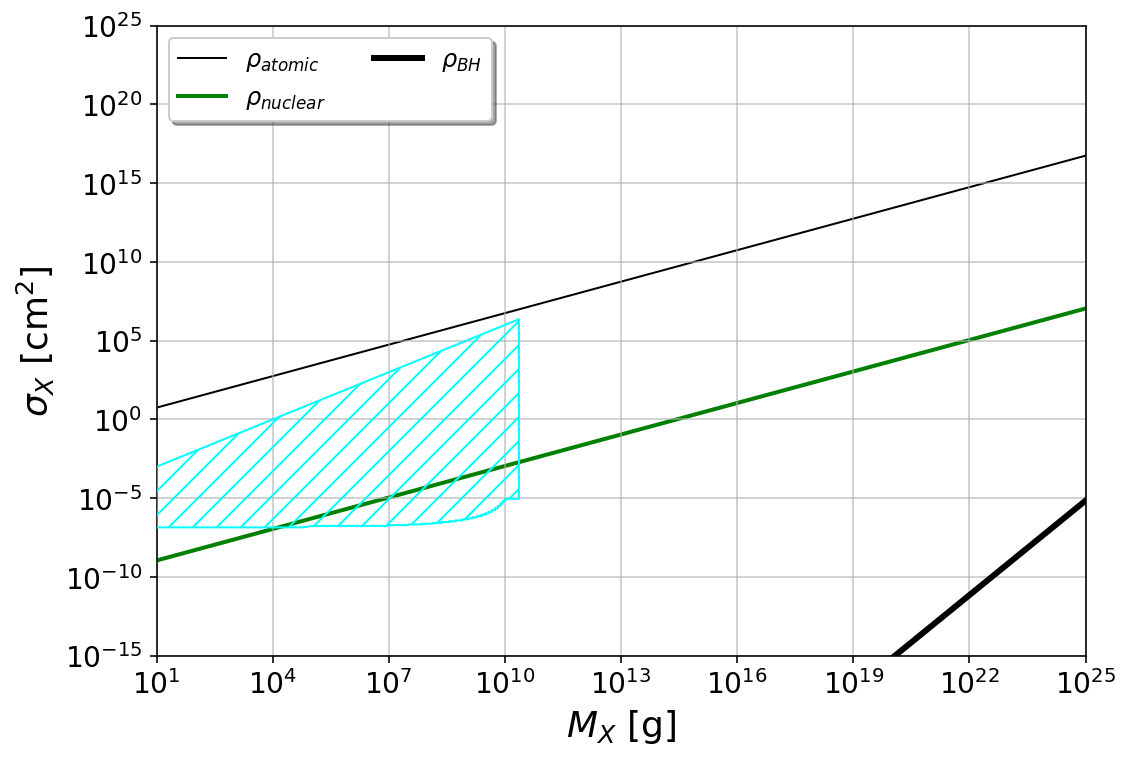

In [12]:
uppersigmalightningjupiter = massJ[:] * 1e-4


with plot.constraints_plot(m_arr, sigmin=sigmin):

    plt.fill_between(
        massJ,
        sigmaJ,
        uppersigmalightningjupiter,
        where=None,
        facecolor="none",
        edgecolor="cyan",
        hatch="//",
        alpha=1.0,
        zorder=4,
    )

plt.show();

### Plotting All Constraints

Plotting both Earth and Jupiter lightning constraints on macro mass and cross-section.

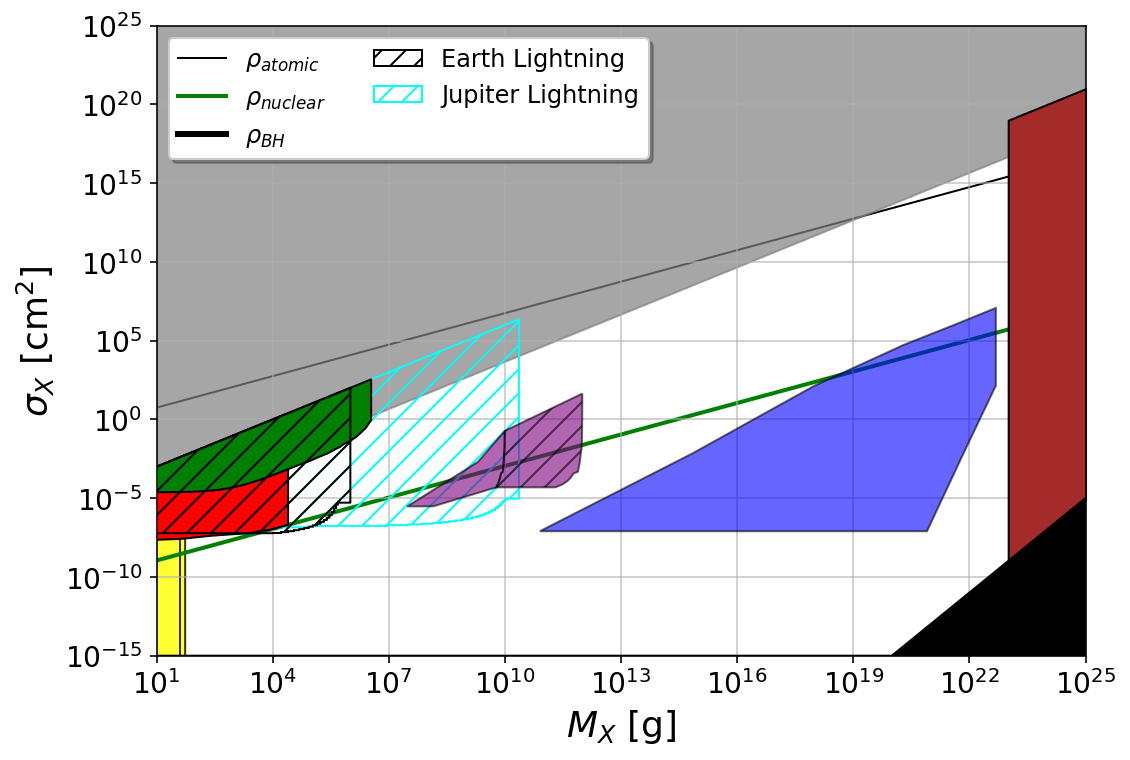

In [13]:
with plot.constraints_plot(
    m_arr=m_arr,
    sigmin=sigmin,
    sigmax=sigmax,
    all_constrs=True,  # previous constraints
    savefig='figures/lightningconstraints.pdf',
) as (fig, ax, m_arr, ymin, ymax):

    plt.fill_between(
        massE, sigmaE, upperlightning,
        where=None, 
        facecolor='none',
        edgecolor='black',
        hatch="//",
        alpha=1.0,
        zorder=8,
        label="Earth Lightning"
    )
    plt.fill_between(
        massJ,
        sigmaJ,
        uppersigmalightningjupiter,
        where=None,
        facecolor="none",
        edgecolor="cyan",
        hatch="//",
        alpha=1.0,
        zorder=4,
        label="Jupiter Lightning"
    )

# /with

plt.show();


<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>